In [1]:
import sys 
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../')
import warnings
import seaborn as sns
# To suppress all warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import  r2_score as r2
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
import seaborn as sns
%matplotlib inline

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
%load_ext autoreload
%autoreload 2
from database import Magneticum
from relation import Scaling
from relation import Distribution
from relation import Analysis
from relation import RandomForest

In [3]:
def data_manupulation(df):
    dff = df.copy()
    dff = dff[['Yksz','Vz','Mstar', 'M','Vlos']]
    dff.Vz = dff.Vz.apply(lambda x: x/1e5)
    dff.Mstar = dff.Mstar.apply(lambda x: np.log(x))
    q_list = [0,0.25,0.5,0.75,1]
    labels = [1,2,3,4]
    dff['M_q'] = pd.qcut(dff['M'],q=q_list,labels=labels)
    return dff

In [4]:
snaps = ['140','116','096']

In [5]:
boxno = 50

In [6]:
df_140 = Analysis(boxno,'140','').get_dataframe()
df_132 = Analysis(boxno,'132','').get_dataframe()
df_120 = Analysis(boxno,'120','').get_dataframe()
df_108 = Analysis(boxno,'108','').get_dataframe()
df_100 = Analysis(boxno,'100','').get_dataframe()

In [7]:
df_140_m = data_manupulation(df_140)
df_132_m = data_manupulation(df_132)
df_120_m = data_manupulation(df_120)    
df_108_m = data_manupulation(df_108)
df_100_m = data_manupulation(df_100)

In [8]:
# plt.figure(figsize=(3,3))
# i = 0
# rmse = []
# r2 = []
# for df in [df_140_m,df_132_m,df_096_m]:
#     slope, intercept = np.polyfit(df.M, df.Yksz, 1)
#     best_fit_line = slope*df.M+intercept
#     rmse.append(mean_squared_error(df.Yksz, best_fit_line,squared=False))
#     r2.append(r2_score(df.Yksz, best_fit_line))
#     plt.plot(df.M, best_fit_line,linewidth=1,label=f'{snaps[i]}-{slope:.2f}-{intercept:.2f}')
#     i+=1
# plt.legend()

In [9]:
#rmse

In [10]:
r2

[0.34849521792878235, 0.32238343273610315, 0.3025901128859617]

In [10]:
def fit_regression_models(df, features, target,df_test=None):
    print(f'Features: {features}')
    X = df[features].values.reshape(-1, len(features))
    y = df[target].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=df.M_q, random_state=42)

    

    # Initialize regression models
    models = {
        "Random Forest Regression": RandomForestRegressor(max_depth=10,min_samples_leaf=4,min_samples_split=10,n_estimators=200, random_state=42),
        "XGB": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
        "GradientBoost": GradientBoostingRegressor(random_state=42),
        }

    results = {}

    for model_name, model in models.items():
        print(f'Running {model_name}...')
        # Fit the model
        # if model_name == "Perceptron":
        #     model.fit(X_train, y_train,)
        # else:
        model.fit(X_train, y_train,sample_weight=np.sqrt(X_train[:,0]))

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        # Evaluate the model
        mse_test = mean_squared_error(y_test, y_pred, squared=False)
        mse_train = mean_squared_error(y_train, y_pred_train, squared=False)
        #r2 = r2_score(y_test, y_pred)

        results[model_name] = {"MSE_test": mse_test, "MSE_train": mse_train}

        if df_test is not None:
            assert type(df_test) == list
            for i,df_ in enumerate(df_test):
                X_ = df_[features].values.reshape(-1, len(features))
                y_ = df_[target].values
                _, X_test_, _, y_test_ = train_test_split(X_, y_, test_size=0.2,stratify=df_.M_q, random_state=42)
                y_pred_ = model.predict(X_test_)
                rmse = mean_squared_error(y_test_, y_pred_, squared=False)
                r2 = r2_score(y_test_, y_pred_)
                results[model_name][f"MSE_{i}"] = rmse
                #results[model_name][f"R-squared_{i}"] = r2
            

        # Plot the results
        # plt.clf()
        # plt.figure(figsize=(6, 4))
        # plt.scatter(X_test[:, 0], y_test, color='blue', label='True')
        # plt.scatter(X_test[:, 0], y_pred, color='red', label='Predicted')
        # plt.xlabel(features[0])
        # plt.ylabel(target)
        # plt.legend()
        # plt.title(f'{model_name} - RMSE: {rmse:.2f}, R-squared: {r2:.2f}')
        # plt.show()

    return results

In [11]:
results_M = fit_regression_models(df_140_m, ['M'], 'Yksz',[df_132_m,df_120_m,df_108_m,df_100_m])

results_MM = fit_regression_models(df_140_m, ['M', 'Mstar'], 'Yksz',[df_132_m,df_120_m,df_108_m,df_100_m])

# Fit models using '[M, Vz]'
results_MVz = fit_regression_models(df_140_m, ['M', 'Vz'], 'Yksz',[df_132_m,df_120_m,df_108_m,df_100_m])

# Fit models using '[M, Mstar, Vz]'
results_MMVz = fit_regression_models(df_140_m, ['M', 'Mstar', 'Vz'], 'Yksz',[df_132_m,df_120_m,df_108_m,df_100_m])


Features: ['M']
Running Random Forest Regression...
Running XGB...
Running GradientBoost...
Features: ['M', 'Mstar']
Running Random Forest Regression...
Running XGB...
Running GradientBoost...
Features: ['M', 'Vz']
Running Random Forest Regression...
Running XGB...
Running GradientBoost...
Features: ['M', 'Mstar', 'Vz']
Running Random Forest Regression...
Running XGB...
Running GradientBoost...


In [12]:
mse_data = {
    '[M]': results_M,
    '[M,Mstar]': results_MM,
    '[M,Vr]': results_MVz,
    '[M,Mstar,Vr]': results_MMVz}

In [13]:
results_M

{'Random Forest Regression': {'MSE_test': 1.2044566958824217,
  'MSE_train': 1.0592730978972194,
  'MSE_0': 1.1652616653665486,
  'MSE_1': 1.1712280203801608,
  'MSE_2': 1.2173580183642922,
  'MSE_3': 1.1762879039342233},
 'XGB': {'MSE_test': 1.199314645186715,
  'MSE_train': 1.115936694799989,
  'MSE_0': 1.1551009612343262,
  'MSE_1': 1.1612424156734966,
  'MSE_2': 1.2062994284243476,
  'MSE_3': 1.1731184510984662},
 'GradientBoost': {'MSE_test': 1.1953594918350674,
  'MSE_train': 1.107352196597254,
  'MSE_0': 1.1482012787593836,
  'MSE_1': 1.1565822336512606,
  'MSE_2': 1.2058114662560155,
  'MSE_3': 1.1681290594331903}}

In [14]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex']=True
plt.rcParams['ytick.minor.visible'] =True
plt.rcParams['xtick.minor.visible'] = True

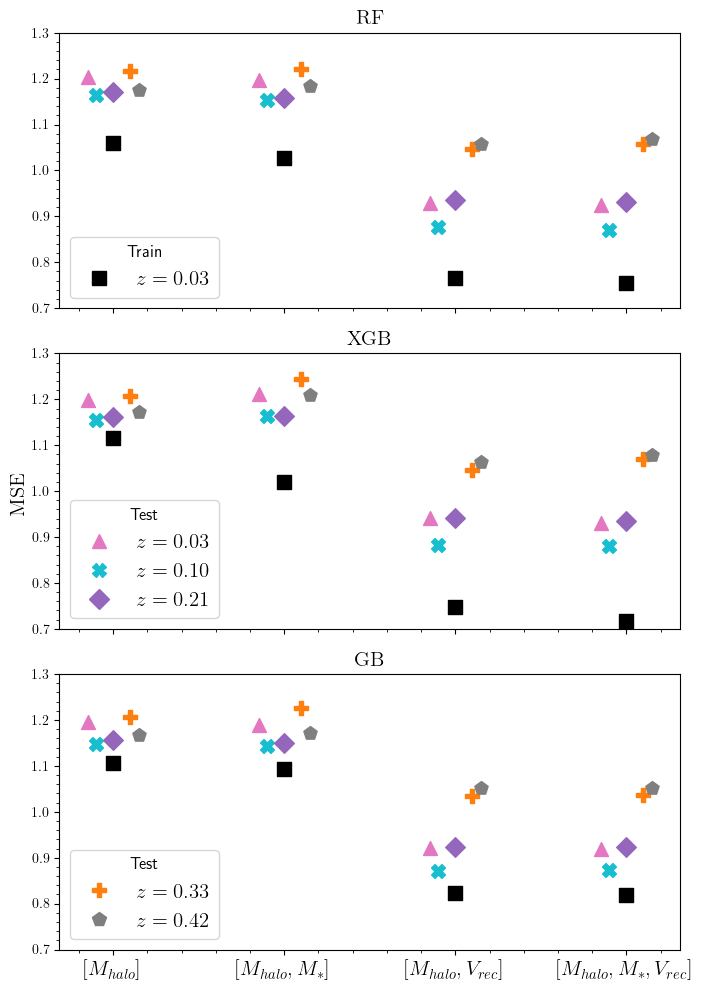

In [15]:

# Define the MSE data

# Define the feature sets for the x-axis
features = ['[M]', '[M,Mstar]', '[M,Vr]', '[M,Mstar,Vr]']
flabel = ['$[M_{halo}]$', '$[M_{halo},M_*]$', '$[M_{halo},V_{rec}]$', '$[M_{halo},M_*,V_{rec}]$']

# Define correct colors for the redshifts
redshift_colors_corrected = ['r', 'b']  # Corrected colors for redshifts

# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(7, 10), sharex=True)

# Adding space between subplots
plt.subplots_adjust(hspace=0.25)

# Set the titles for each model
titles = ['Random Forest Regression', 'XGB', 'GradientBoost']
tlables = ['$\\rm RF$', '$\\rm XGB$', '$\\rm GB$']

# Iterate over each axis to plot the data
pp = 0
for ax, title in zip(axes, titles):
    ax.set_title(tlables[pp],fontsize=15)
    pp+=1
    #ax.grid(True,)  # Enable grid

    # Iterate over each feature set for the current model
    for i, (feature_set, results) in enumerate(mse_data.items()):
        # Extract the MSE values for each type
        mse_train = results[title]['MSE_train']
        mse_test = results[title]['MSE_test']
        mse_0 = results[title]['MSE_0']
        mse_1 = results[title]['MSE_1']
        mse_2 = results[title]['MSE_2']
        mse_3 = results[title]['MSE_3']

        # Define x position for each MSE type
        x_positions = [i - 0.15, i-0.1, i,i+0.1, i + 0.15]

        # Plot the train and test MSE
        ax.scatter(x_positions[2], mse_train, color='black', marker='s', s=100) # facecolors='none'
        ax.scatter(x_positions[0], mse_test, color='C6', marker='^', s=100)
        # Plot the MSE_0 and MSE_1 with corrected redshift colors
        ax.scatter(x_positions[1], mse_0, color='C9', marker='X', s=100)
        ax.scatter(x_positions[2], mse_1, color='C4', marker='D', s=100)
        ax.scatter(x_positions[3], mse_2, color='C1', marker='P' , s=100)
        ax.scatter(x_positions[4], mse_3, color='C7', marker='p', s=100)
        plt.xticks(fontsize=15)

    # Setting the x-axis labels only on the last subplot
    ax.set_ylim(0.7,1.3)
    plt.xticks(fontsize=15)
    
    if ax is axes[-1]:
        ax.set_xticks(range(len(features)))
        ax.set_xticklabels(flabel,fontsize=15)
    else:
        
        ax.set_xticks([])  # Hide x-tick labels for the upper subplots
    
    
    
    

# Set common y-label
fig.text(-0.01, 0.5, '$ \\rm MSE$', va='center', rotation='vertical',fontsize=15)

# Creating two legends with correct labels and colors
labels_1 = ['$z = 0.03$']
labels_2 = ['$z = 0.03$', '$z = 0.10$', '$z = 0.21$'] 
labels_3 = ['$z = 0.33$','$z=0.42$']

# Legend elements for Train and Test
legend_elements_1 = [plt.Line2D([0], [0], color='black', marker='s', linestyle='None', markersize=10, ),] #markerfacecolor='none'
                     #plt.Line2D([0], [0], color='black', marker='s', linestyle='None', markersize=10)]

# Legend elements for Redshifts
legend_elements_2 = [plt.Line2D([0], [0], color='C6', marker='^', linestyle='None', markersize=10),
                     plt.Line2D([0], [0], color='C9', marker='X', linestyle='None', markersize=10),
                     plt.Line2D([0], [0], color='C4', marker='D', linestyle='None', markersize=10)]

legend_elements_3 = [plt.Line2D([0], [0], color='C1', marker='P', linestyle='None', markersize=10),
                     plt.Line2D([0], [0], color='C7', marker='p', linestyle='None', markersize=10)]

# Place the first legend on the first subplot and the second legend on the last subplot
axes[0].legend(legend_elements_1, labels_1, loc='lower left',title='Train',fontsize=15)
axes[1].legend(legend_elements_2, labels_2, loc='lower left', title='Test',fontsize=15)
axes[2].legend(legend_elements_3, labels_3, loc='lower left', title='Test',fontsize=15)

# Adjust the title of the legends
axes[0].get_legend().get_title().set_fontsize('large')
axes[1].get_legend().get_title().set_fontsize('large')
axes[2].get_legend().get_title().set_fontsize('large')


plt.tight_layout()
plt.savefig('MSE_cross.pdf',dpi=300,bbox_inches='tight')


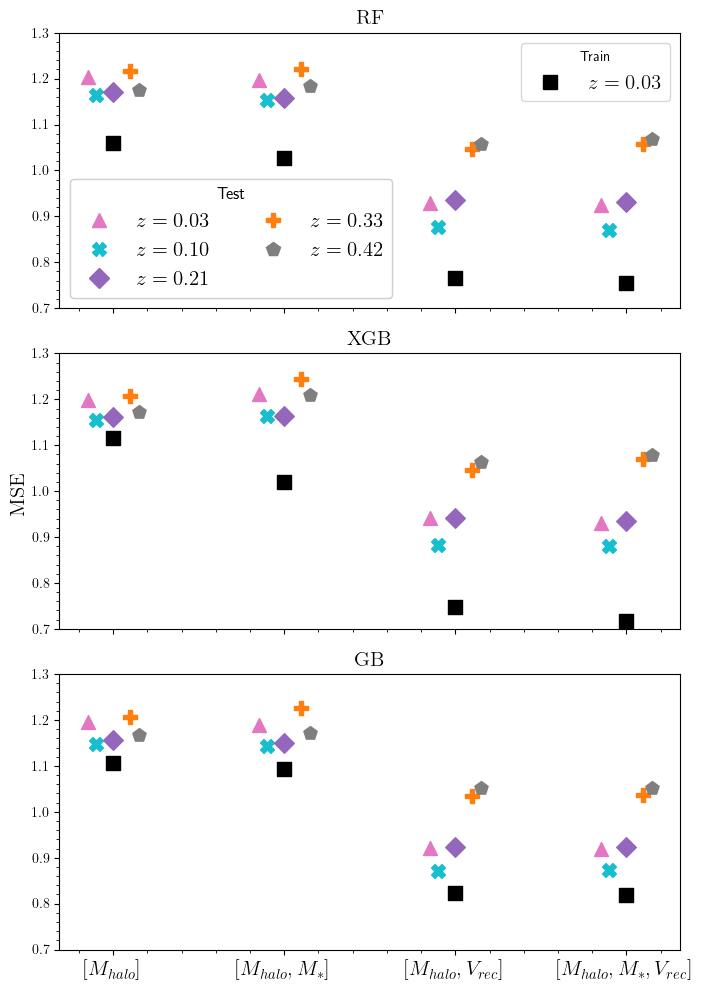

In [22]:

# Define the MSE data

# Define the feature sets for the x-axis
features = ['[M]', '[M,Mstar]', '[M,Vr]', '[M,Mstar,Vr]']
flabel = ['$[M_{halo}]$', '$[M_{halo},M_*]$', '$[M_{halo},V_{rec}]$', '$[M_{halo},M_*,V_{rec}]$']

# Define correct colors for the redshifts
redshift_colors_corrected = ['r', 'b']  # Corrected colors for redshifts

# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(7, 10), sharex=True)

# Adding space between subplots
plt.subplots_adjust(hspace=0.25)

# Set the titles for each model
titles = ['Random Forest Regression', 'XGB', 'GradientBoost']
tlables = ['$\\rm RF$', '$\\rm XGB$', '$\\rm GB$']

# Iterate over each axis to plot the data
pp = 0
for ax, title in zip(axes, titles):
    ax.set_title(tlables[pp],fontsize=15)
    pp+=1
    #ax.grid(True,)  # Enable grid

    # Iterate over each feature set for the current model
    for i, (feature_set, results) in enumerate(mse_data.items()):
        # Extract the MSE values for each type
        mse_train = results[title]['MSE_train']
        mse_test = results[title]['MSE_test']
        mse_0 = results[title]['MSE_0']
        mse_1 = results[title]['MSE_1']
        mse_2 = results[title]['MSE_2']
        mse_3 = results[title]['MSE_3']

        # Define x position for each MSE type
        x_positions = [i - 0.15, i-0.1, i,i+0.1, i + 0.15]

        # Plot the train and test MSE
        ax.scatter(x_positions[2], mse_train, color='black', marker='s', s=100) # facecolors='none'
        ax.scatter(x_positions[0], mse_test, color='C6', marker='^', s=100)
        # Plot the MSE_0 and MSE_1 with corrected redshift colors
        ax.scatter(x_positions[1], mse_0, color='C9', marker='X', s=100)
        ax.scatter(x_positions[2], mse_1, color='C4', marker='D', s=100)
        ax.scatter(x_positions[3], mse_2, color='C1', marker='P' , s=100)
        ax.scatter(x_positions[4], mse_3, color='C7', marker='p', s=100)
        plt.xticks(fontsize=15)

    # Setting the x-axis labels only on the last subplot
    ax.set_ylim(0.7,1.3)
    plt.xticks(fontsize=15)
    
    if ax is axes[-1]:
        ax.set_xticks(range(len(features)))
        ax.set_xticklabels(flabel,fontsize=15)
    else:
        
        ax.set_xticks([])  # Hide x-tick labels for the upper subplots
    
    
    
    

# Set common y-label
fig.text(-0.01, 0.5, '$ \\rm MSE$', va='center', rotation='vertical',fontsize=15)

# Creating two legends with correct labels and colors
labels_1 = ['$z = 0.03$']
labels_2 = ['$z = 0.03$', '$z = 0.10$', '$z = 0.21$','$z = 0.33$','$z=0.42$'] 

# Legend elements for Train and Test
legend_elements_1 = [plt.Line2D([0], [0], color='black', marker='s', linestyle='None', markersize=10, ),] #markerfacecolor='none'
                     #plt.Line2D([0], [0], color='black', marker='s', linestyle='None', markersize=10)]

# Legend elements for Redshifts
legend_elements_2 = [plt.Line2D([0], [0], color='C6', marker='^', linestyle='None', markersize=10),
                     plt.Line2D([0], [0], color='C9', marker='X', linestyle='None', markersize=10),
                     plt.Line2D([0], [0], color='C4', marker='D', linestyle='None', markersize=10),
                     plt.Line2D([0], [0], color='C1', marker='P', linestyle='None', markersize=10),
                     plt.Line2D([0], [0], color='C7', marker='p', linestyle='None', markersize=10)]

# Place the first legend on the first subplot and the second legend on the last subplot
legend1 = axes[0].legend(legend_elements_1, labels_1, loc='upper right',title='Train',fontsize=15)
legend2 = axes[0].legend(legend_elements_2, labels_2,ncol=2, loc='lower left', title='Test',fontsize=15)

axes[0].add_artist(legend1)
axes[0].add_artist(legend2)

#axes[2].legend(legend_elements_3, labels_3, loc='lower left', title='Test',fontsize=15)

# Adjust the title of the legends
axes[0].get_legend().get_title().set_fontsize('large')
#axes[1].get_legend().get_title().set_fontsize('large')
#axes[2].get_legend().get_title().set_fontsize('large')


plt.tight_layout()
plt.savefig('MSE_cross_upd.pdf',dpi=300,bbox_inches='tight')


In [ ]:

# Print and compare the results
for feature_set, result in zip(['M', '[M, Mstar]', '[M, Vz]', '[M, Mstar, Vz]'],
                               [results_M, results_MMstar, results_MVz, results_MMVz]):
    print(f"Results for {feature_set}:")
    for model_name, metrics in result.items():
        print(f"{model_name} - RMSE: {metrics['RMSE']:.2f}, R-squared: {metrics['R-squared']:.2f}")
    print()

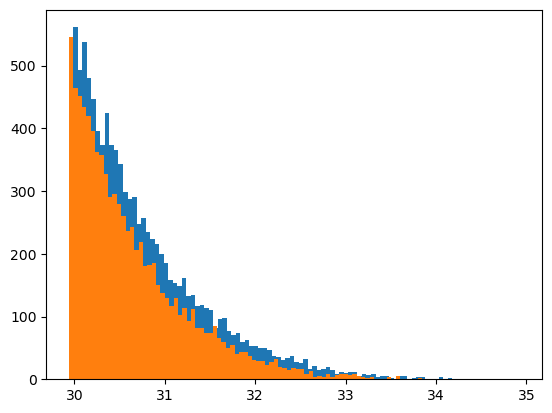

In [26]:
n = plt.hist(df_140_m.M,bins=100)
n = plt.hist(df_096_m.M,bins=100)

In [27]:
print('140',len(df_140_m.M))
print('096',len(df_096_m.M))

140 10493
096 8599


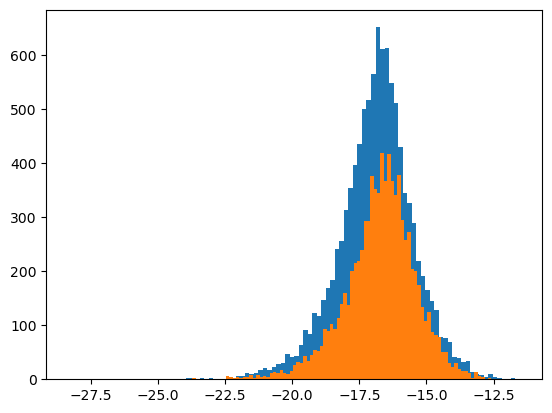

In [28]:
n = plt.hist(df_140_m.Yksz,bins=100)
n = plt.hist(df_096_m.Yksz,bins=100)

In [52]:
pearsonr(df_140_m.Yksz[df_140_m.M<33],df_140_m.M[df_140_m.M<33])

(0.5639905631636601, 0.0)

In [45]:
pearsonr(df_096_m.Yksz,df_096_m.M)

(0.5500819147054026, 0.0)

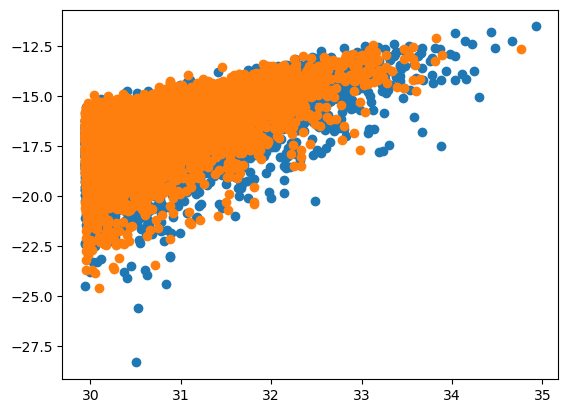

In [37]:
plt.scatter(df_140_m.M,df_140_m.Yksz)
plt.scatter(df_096_m.M,df_096_m.Yksz)

In [46]:
df_140_m.M_q.value_counts() 

1    2624
2    2623
3    2623
4    2623
Name: M_q, dtype: int64

In [47]:
df_096_m.M_q.value_counts()

1    2150
2    2150
4    2150
3    2149
Name: M_q, dtype: int64

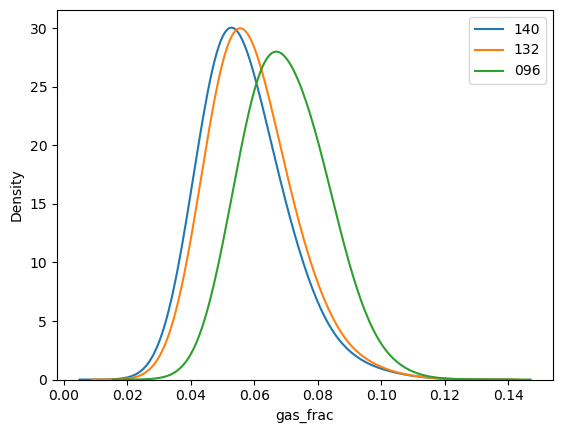

In [30]:
sns.kdeplot(df_140.gas_frac,bw_adjust=3,label='140')
sns.kdeplot(df_132.gas_frac,bw_adjust=3,label='132')
sns.kdeplot(df_096.gas_frac,bw_adjust=3,label='096')
plt.legend()

In [1]:
import numpy as np

In [3]:
a = np.array([1,2,3,4,5,6,7,8,9,10])

In [ ]:
np.